In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

### Import data

In [47]:
url = "https://raw.githubusercontent.com/ccodwg/Covid19Canada/master/timeseries_prov/cases_timeseries_prov.csv"
df = pd.read_csv(url)
df["date_report"] = pd.to_datetime(df["date_report"], format="%d-%m-%Y")
df.head()

,province,date_report,cases,cumulative_cases
0,Alberta,2020-01-25,0,0
1,Alberta,2020-01-26,0,0
2,Alberta,2020-01-27,0,0
3,Alberta,2020-01-28,0,0
4,Alberta,2020-01-29,0,0


### Cleaning and transforming

In [108]:
# df.columns = [x.lower() for x in df.columns]
indexer = df[df["province"]=="BC"].index
bc_df = df.loc[indexer, "date_report":"cases"]
bc_df.set_index("date_report", inplace=True)
bc_df["t30_cases"] = bc_df.rolling(window=30).mean()["cases"]
bc_df.drop(bc_df.columns.difference(["t30_cases"]), 1, inplace=True) # drop all other cols
bc_df = bc_df.asfreq("d")
bc_df.dropna(inplace=True)
bc_df.head(10)

,t30_cases
date_report,
2020-02-23,0.200000
2020-02-24,0.233333
2020-02-25,0.233333
2020-02-26,0.233333
2020-02-27,0.200000
2020-02-28,0.200000
2020-02-29,0.233333
2020-03-01,0.233333
2020-03-02,0.233333


<AxesSubplot:xlabel='date_report'>

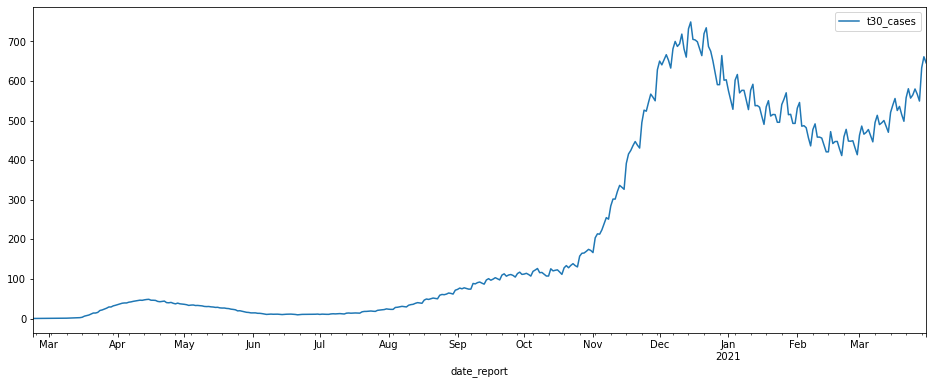

In [109]:
bc_df.plot(figsize=(16,6))
# bc_df["rollmean_7_cases"].plot()

### Train-test split based on 80:20

In [122]:
train_df = bc_df[:int(bc_df.shape[0]*0.8)]
test_df = bc_df[int(bc_df.shape[0]*0.8):]
test_df.head(10)

,t30_cases
date_report,
2021-01-10,527.833333
2021-01-11,577.000000
2021-01-12,591.866667
2021-01-13,537.633333
2021-01-14,538.166667
2021-01-15,533.800000
2021-01-16,511.366667
2021-01-17,490.566667
2021-01-18,534.900000


### Holt-Winters model

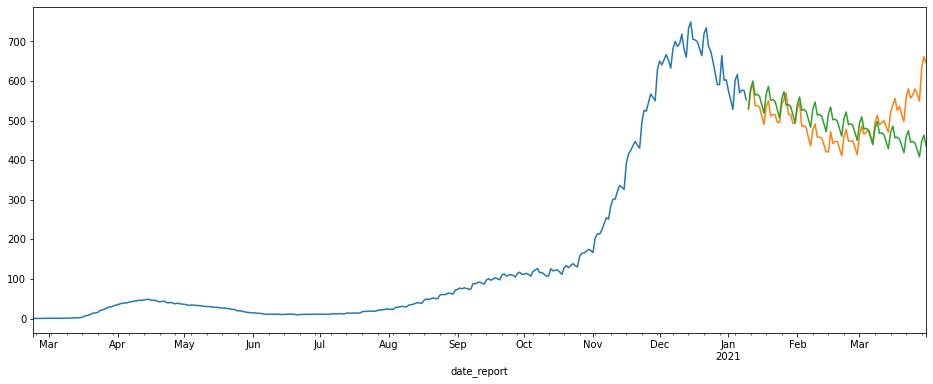

In [145]:
model = ExponentialSmoothing(train_df["t30_cases"],
                             trend="add",
                             seasonal="add",
                             use_boxcox=True,
                             initialization_method="estimated")
model_fit = model.fit()
prediction = model_fit.forecast(81)

prediction.head(10)
#Plot training, testing and projection data
train_df["t30_cases"].plot(figsize=(16,6))
test_df["t30_cases"].plot()
prediction.plot()
plt.show()

In [132]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAE: ", mean_absolute_error(test_df, prediction))
print("MSE: ", mean_squared_error(test_df, prediction))
print("RMSE: ", np.sqrt(mean_squared_error(test_df, prediction)))
print("MAPE: ", mean_absolute_percentage_error(test_df, prediction)) # watch out for divide by zero error

MAE:  57.826225438490155
MSE:  4335.910060420056
RMSE:  65.84762759902634
MAPE:  11.991078282646829
